In [16]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [8]:
data = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv', date_format='%Y-%m', index_col=0)
data.head()

,Sunspots
Month,
1749-01-01,58.0
1749-02-01,62.6
1749-03-01,70.0
1749-04-01,55.7
1749-05-01,85.0


In [10]:
train_size = int(0.8 * len(data.index))
train = data.iloc[:train_size]
test = data.iloc[train_size:]

,Sunspots
Month,
1749-01-01,58.0
1749-02-01,62.6
1749-03-01,70.0
1749-04-01,55.7
1749-05-01,85.0


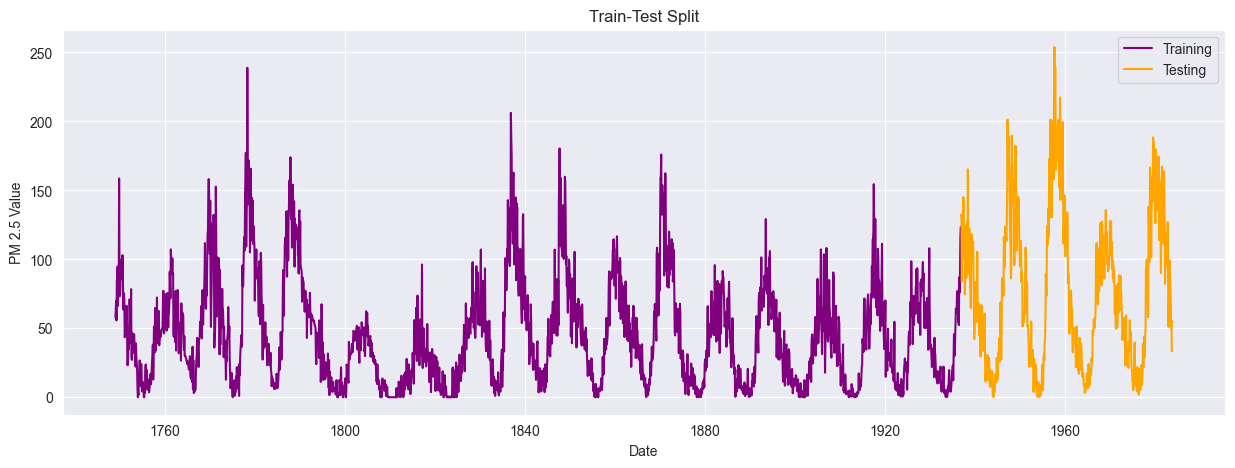

In [11]:
fig = plt.figure(figsize=(15,5))
plt.plot(train, color='purple', label='Training')
plt.plot(test, color='orange', label='Testing')
plt.xlabel('Date')
plt.ylabel('PM 2.5 Value')
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [17]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.fit_transform(test)

In [20]:
def get_sequences(data_p, sequence_length):
    sequences = []
    target = []
    
    for i in range(sequence_length, len(data_p)):
        sequences.append(data_p[i - sequence_length:i, 0])
        target.append(data_p[i, 0])
        
    np_sequences = np.array(sequences)
    np_target = np.array(target)
        
    return np.reshape(np_sequences, (np_sequences.shape[0], np_sequences.shape[1], 1)), np.reshape(np_target, (np_target.shape[0], 1))

In [21]:
X_train, y_train = get_sequences(scaled_train, 5)
X_test, y_test = get_sequences(scaled_test, 5)

In [39]:
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

In [25]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = keras.callbacks.ModelCheckpoint('./models/rnn.keras', monitor='val_loss', save_best_only=True)

# RNN Simple

In [55]:
rnn_model = keras.models.Sequential()
rnn_model.add(keras.layers.Input(shape=(X_train.shape[1],1)))
rnn_model.add(keras.layers.SimpleRNN(
    units=128, 
    activation='tanh',
    return_sequences=True
))
rnn_model.add(keras.layers.Dropout(0.2))
rnn_model.add(keras.layers.SimpleRNN(
    units=64, 
    activation='tanh',
    return_sequences=True
))
rnn_model.add(keras.layers.Dropout(0.5))
rnn_model.add(keras.layers.SimpleRNN(
    units=32, 
    activation='tanh',
    return_sequences=False
))
rnn_model.add(keras.layers.Dropout(0.2))

rnn_model.add(keras.layers.Dense(units=1))

rnn_model.compile(loss='mse', optimizer='RMSprop', metrics=['accuracy'])
rnn_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_12 (SimpleRNN)       │ (None, 5, 128)         │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_13 (SimpleRNN)       │ (None, 5, 64)          │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_14 (SimpleRNN)       │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,129 (125.50 KB)

 Trainable params: 32,129 (125.50 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
history = rnn_model.fit(X_train, y_train, epochs=100, batch_size=1, validation_split=0.25, verbose=2, callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
1688/1688 - 4s - 2ms/step - accuracy: 0.0361 - loss: 0.0429 - val_accuracy: 0.0124 - val_loss: 0.0058
Epoch 2/100
1688/1688 - 3s - 2ms/step - accuracy: 0.0355 - loss: 0.0121 - val_accuracy: 0.0124 - val_loss: 0.0051
Epoch 3/100
1688/1688 - 3s - 2ms/step - accuracy: 0.0355 - loss: 0.0085 - val_accuracy: 0.0124 - val_loss: 0.0050
Epoch 4/100
1688/1688 - 3s - 2ms/step - accuracy: 0.0355 - loss: 0.0070 - val_accuracy: 0.0124 - val_loss: 0.0053
Epoch 5/100
1688/1688 - 3s - 2ms/step - accuracy: 0.0355 - loss: 0.0066 - val_accuracy: 0.0124 - val_loss: 0.0046
Epoch 6/100
1688/1688 - 3s - 2ms/step - accuracy: 0.0361 - loss: 0.0061 - val_accuracy: 0.0124 - val_loss: 0.0039
Epoch 7/100
1688/1688 - 3s - 2ms/step - accuracy: 0.0361 - loss: 0.0060 - val_accuracy: 0.0124 - val_loss: 0.0050
Epoch 8/100
1688/1688 - 3s - 2ms/step - accuracy: 0.0361 - loss: 0.0061 - val_accuracy: 0.0124 - val_loss: 0.0038
Epoch 9/100
1688/1688 - 3s - 2ms/step - accuracy: 0.0361 - loss: 0.0062 - val_accuracy: 

In [57]:
y_rnn = rnn_model.predict(X_test)
y_rnn = scaler.inverse_transform(y_rnn)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


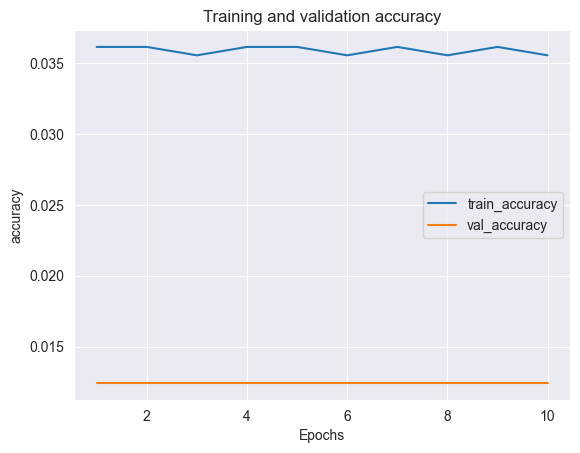

In [45]:
plot_metric(history, 'accuracy')

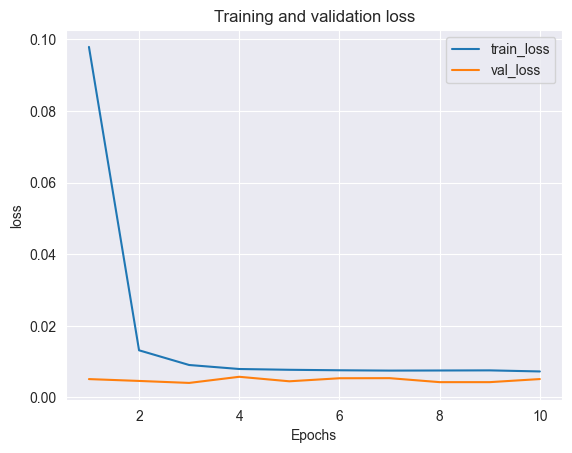

In [46]:
plot_metric(history, 'loss')

## Feed Forward NN

In [58]:
ffnn_model = keras.models.Sequential()
ffnn_model.add(keras.layers.Input(shape=(X_train.shape[1],1)))
ffnn_model.add(keras.layers.Flatten())
ffnn_model.add(keras.layers.Dense(
    units=128, 
    activation='tanh',
))
ffnn_model.add(keras.layers.Dropout(0.2))
ffnn_model.add(keras.layers.Dense(
    units=64, 
    activation='tanh',
))
ffnn_model.add(keras.layers.Dropout(0.5))
ffnn_model.add(keras.layers.Dense(
    units=32, 
    activation='tanh',
))
ffnn_model.add(keras.layers.Dropout(0.2))

ffnn_model.add(keras.layers.Dense(units=1))

ffnn_model.compile(loss='mse', optimizer='RMSprop', metrics=['accuracy'])
ffnn_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,137 (43.50 KB)

 Trainable params: 11,137 (43.50 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
model_checkpoint = keras.callbacks.ModelCheckpoint('./models/ffnn.keras', monitor='val_loss', save_best_only=True)
ffnn_history = ffnn_model.fit(X_train, y_train, epochs=100, batch_size=1, validation_split=0.25, verbose=2, callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
1688/1688 - 1s - 870us/step - accuracy: 0.0361 - loss: 0.0151 - val_accuracy: 0.0124 - val_loss: 0.0037
Epoch 2/100
1688/1688 - 1s - 554us/step - accuracy: 0.0361 - loss: 0.0084 - val_accuracy: 0.0124 - val_loss: 0.0040
Epoch 3/100
1688/1688 - 1s - 561us/step - accuracy: 0.0361 - loss: 0.0070 - val_accuracy: 0.0124 - val_loss: 0.0037
Epoch 4/100
1688/1688 - 1s - 545us/step - accuracy: 0.0361 - loss: 0.0065 - val_accuracy: 0.0124 - val_loss: 0.0035
Epoch 5/100
1688/1688 - 1s - 576us/step - accuracy: 0.0361 - loss: 0.0060 - val_accuracy: 0.0124 - val_loss: 0.0044
Epoch 6/100
1688/1688 - 1s - 609us/step - accuracy: 0.0355 - loss: 0.0062 - val_accuracy: 0.0124 - val_loss: 0.0037
Epoch 7/100
1688/1688 - 1s - 632us/step - accuracy: 0.0361 - loss: 0.0058 - val_accuracy: 0.0124 - val_loss: 0.0040
Epoch 8/100
1688/1688 - 1s - 562us/step - accuracy: 0.0361 - loss: 0.0058 - val_accuracy: 0.0124 - val_loss: 0.0039
Epoch 9/100
1688/1688 - 1s - 539us/step - accuracy: 0.0361 - loss: 0.005

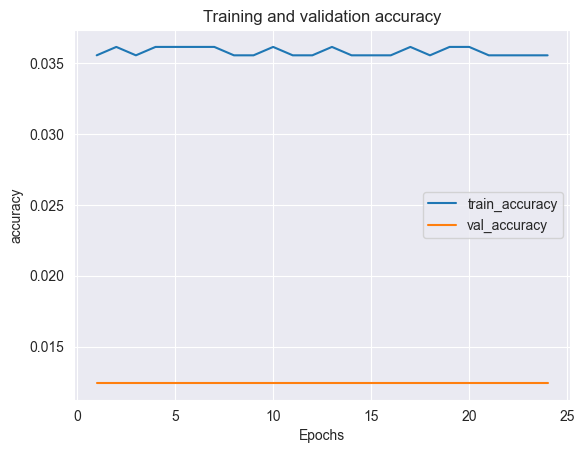

In [50]:
plot_metric(ffnn_history, 'accuracy')

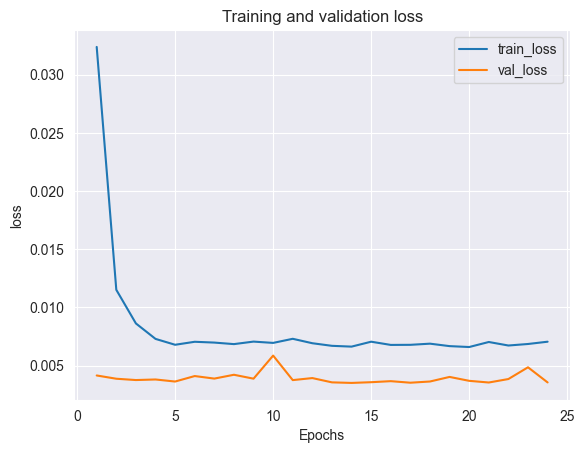

In [51]:
plot_metric(ffnn_history, 'loss')

In [60]:
y_ffnn = ffnn_model.predict(X_test)
y_ffnn = scaler.inverse_transform(y_ffnn)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


## GRU RNN

In [62]:
gru_model = keras.models.Sequential()
gru_model.add(keras.layers.Input(shape=(X_train.shape[1],1)))
gru_model.add(keras.layers.GRU(
    units=128, 
    activation='tanh',
    return_sequences=True
))
gru_model.add(keras.layers.Dropout(0.2))
gru_model.add(keras.layers.GRU(
    units=64, 
    activation='tanh',
    return_sequences=True
))
gru_model.add(keras.layers.Dropout(0.5))
gru_model.add(keras.layers.GRU(
    units=32, 
    activation='tanh',
    return_sequences=False
))
gru_model.add(keras.layers.Dropout(0.2))

gru_model.add(keras.layers.Dense(units=1))

gru_model.compile(loss='mse', optimizer='RMSprop', metrics=['accuracy'])
gru_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 5, 128)         │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 5, 64)          │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,993 (378.88 KB)

 Trainable params: 96,993 (378.88 KB)

 Non-trainable params: 0 (0.00 B)

In [63]:
model_checkpoint = keras.callbacks.ModelCheckpoint('./models/gru.keras', monitor='val_loss', save_best_only=True)
gru_history = gru_model.fit(X_train, y_train, epochs=100, batch_size=1, validation_split=0.25, verbose=2, callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
1688/1688 - 6s - 3ms/step - accuracy: 0.0355 - loss: 0.0082 - val_accuracy: 0.0124 - val_loss: 0.0048
Epoch 2/100
1688/1688 - 4s - 2ms/step - accuracy: 0.0361 - loss: 0.0068 - val_accuracy: 0.0124 - val_loss: 0.0039
Epoch 3/100
1688/1688 - 4s - 2ms/step - accuracy: 0.0355 - loss: 0.0068 - val_accuracy: 0.0124 - val_loss: 0.0044
Epoch 4/100
1688/1688 - 4s - 2ms/step - accuracy: 0.0361 - loss: 0.0059 - val_accuracy: 0.0124 - val_loss: 0.0036
Epoch 5/100
1688/1688 - 3s - 2ms/step - accuracy: 0.0361 - loss: 0.0057 - val_accuracy: 0.0124 - val_loss: 0.0053
Epoch 6/100
1688/1688 - 4s - 2ms/step - accuracy: 0.0355 - loss: 0.0057 - val_accuracy: 0.0124 - val_loss: 0.0038
Epoch 7/100
1688/1688 - 4s - 2ms/step - accuracy: 0.0361 - loss: 0.0056 - val_accuracy: 0.0124 - val_loss: 0.0035
Epoch 8/100
1688/1688 - 4s - 2ms/step - accuracy: 0.0355 - loss: 0.0052 - val_accuracy: 0.0124 - val_loss: 0.0040
Epoch 9/100
1688/1688 - 4s - 2ms/step - accuracy: 0.0355 - loss: 0.0053 - val_accuracy: 

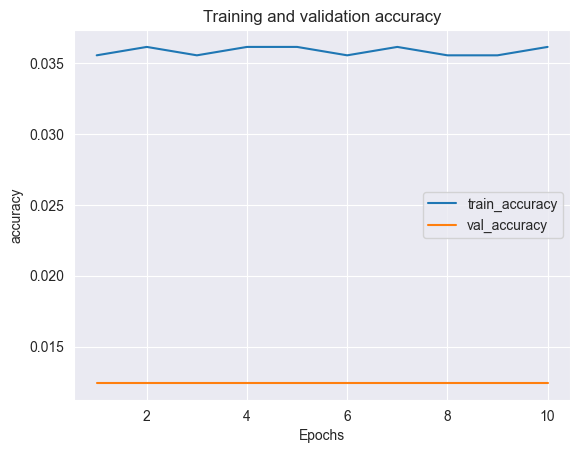

In [64]:
plot_metric(gru_history, 'accuracy')

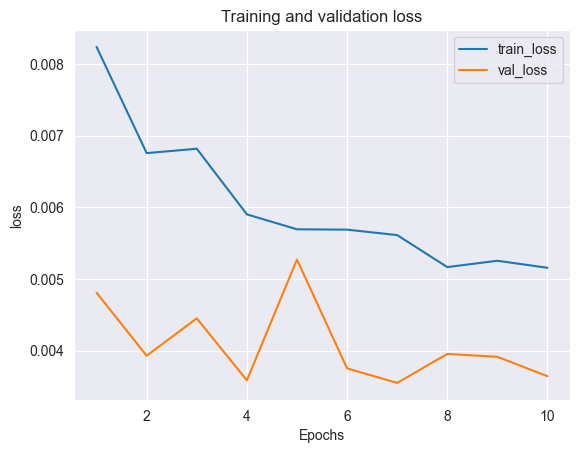

In [65]:
plot_metric(gru_history, 'loss')

In [66]:
y_gru = gru_model.predict(X_test)
y_gru = scaler.inverse_transform(y_gru)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


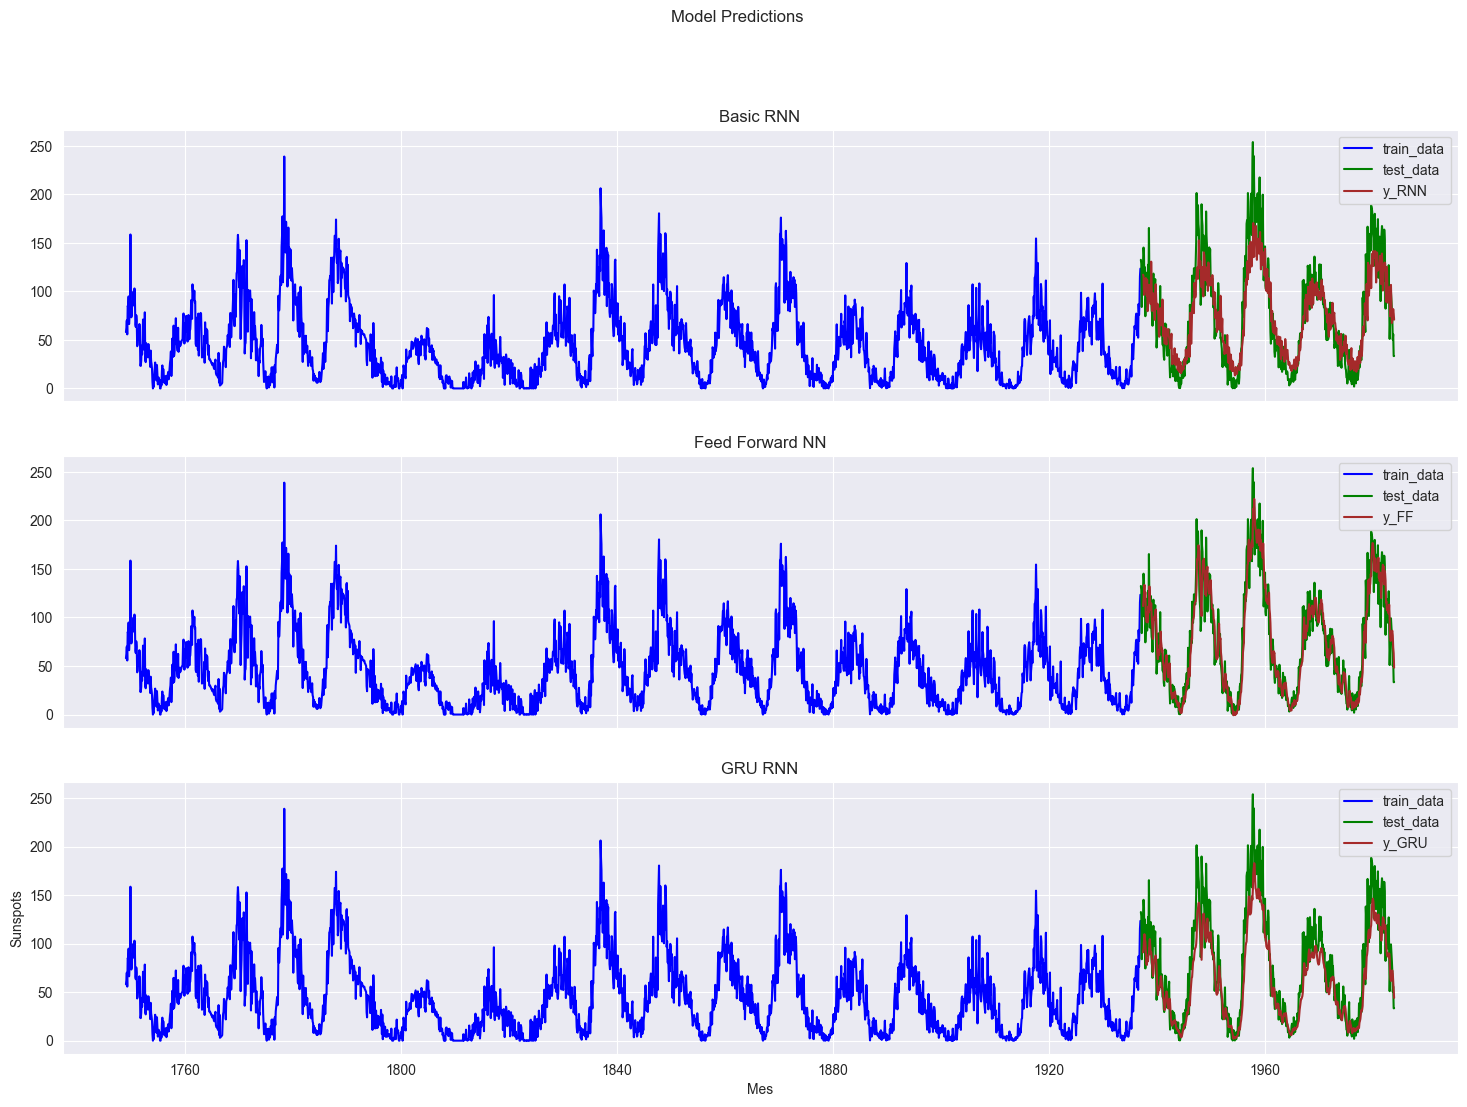

In [68]:
fig, axs = plt.subplots(3,figsize =(18,12),sharex=True, sharey=True)
fig.suptitle('Model Predictions')
 
#Plot for RNN predictions
axs[0].plot(train.index, train['Sunspots'], label = "train_data", color = "b")
axs[0].plot(test.index, test['Sunspots'], label = "test_data", color = "g")
axs[0].plot(test.index[5:], y_rnn, label = "y_RNN", color = "brown")
axs[0].legend()
axs[0].title.set_text("Basic RNN")

#Plot for Feed Forward NN predictions
axs[1].plot(train.index, train['Sunspots'], label = "train_data", color = "b")
axs[1].plot(test.index, test['Sunspots'], label = "test_data", color = "g")
axs[1].plot(test.index[5:], y_ffnn, label = "y_FF", color = "brown")
axs[1].legend()
axs[1].title.set_text("Feed Forward NN")

#Plot for GRU RNN predictions
axs[2].plot(train.index, train['Sunspots'], label = "train_data", color = "b")
axs[2].plot(test.index, test['Sunspots'], label = "test_data", color = "g")
axs[2].plot(test.index[5:], y_gru, label = "y_GRU", color = "brown")
axs[2].legend()
axs[2].title.set_text("GRU RNN")

plt.xlabel("Mes")
plt.ylabel("Sunspots")
 
plt.show()